# Naive Bayes for image classification

This notebook demonstrates the process of training a Naive Bayes model for image classification using the **CoronaHack Chest X-Ray Dataset**. The key steps include:

- Data preprocessing and feature extraction
- Training a Naive Bayes model
- Evaluating model performance

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import joblib  # For saving and loading trained models
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # For enhanced plots
from PIL import Image  # For image processing
from sklearn.naive_bayes import GaussianNB  # Naive Bayes classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics

### 1. Prepare Data
In this section, we **load and preprocess the dataset** by reading metadata from the **CoronaHack Chest X-Ray dataset**, filtering relevant cases, and assigning categorical labels for classification. We then partition the data into training and testing sets and prepare file paths for image processing. This step ensures the dataset is clean, structured, and ready for feature extraction.

In [2]:
# Define paths to dataset
SOURCE_DATA_DIR = "../../data/raw/"
INFO_FILE = os.path.join(SOURCE_DATA_DIR, "Chest_xray_Corona_Metadata.csv")

# Function to read metadata CSV file
def read_metadata():
    return pd.read_csv(INFO_FILE)

# Load metadata and remove unnecessary columns
metadata = read_metadata()
metadata = metadata.loc[:, ~metadata.columns.str.contains('Unnamed: 0')]
metadata

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [3]:
# Process metadata and assign categories based on labels
def process_and_label_data(metadata):
    # Select only relevant cases (Normal and Pneumonia with Virus/Bacteria)
    selected_data = metadata[(metadata["Label"] == "Normal") |
                             ((metadata["Label"] == "Pnemonia") & metadata["Label_1_Virus_category"].isin(["Virus", "bacteria"]))].copy()
    category = []
    for _, row in selected_data.iterrows():
        if row["Label"] == "Normal":
            category.append(1)  # Assign category 1 to normal cases
        elif row["Label"] == "Pnemonia" and row["Label_1_Virus_category"] == "Virus":
            category.append(2)  # Assign category 2 to viral pneumonia
        elif row["Label"] == "Pnemonia" and row["Label_1_Virus_category"] == "bacteria":
            category.append(3)  # Assign category 3 to bacterial pneumonia
    selected_data["Category"] = category
    return selected_data

# Processed dataset
processed_data = process_and_label_data(metadata)
processed_data

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,1
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,1
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,1
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,1
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,1
...,...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus,2
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus,2
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus,2
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus,2


In [4]:
# Split dataset into training and testing sets
def partition_data(metadata):
    train_set = metadata[metadata["Dataset_type"] == "TRAIN"]
    test_set = metadata[metadata["Dataset_type"] == "TEST"]
    
    # Get file paths for images
    train_images = [os.path.join(SOURCE_DATA_DIR, 'Coronahack-Chest-XRay-Dataset/train/', fname) for fname in train_set["X_ray_image_name"].values]
    test_images = [os.path.join(SOURCE_DATA_DIR, 'Coronahack-Chest-XRay-Dataset/test/', fname) for fname in test_set["X_ray_image_name"].values]
    
    return train_images, test_images, train_set["Category"].values, test_set["Category"].values

# Partition data into images and labels
train_images, test_images, train_labels, test_labels = partition_data(processed_data)
train_images[:7], test_images[:7], train_labels[:7], test_labels[:7]

(['../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0127-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0125-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0122-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0119-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0117-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0115-0001.jpeg'],
 ['../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0021-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0019-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0017-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0016-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0015-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0013-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dat

### 2. Features Extraction

In this section, we **process the images** by converting them to grayscale, resizing them to a uniform size, and normalizing pixel values. Each image is then **flattened into a feature vector**, making it suitable for input into the Naive Bayes classifier.


In [5]:
# Preprocess images by resizing, converting to grayscale, and normalizing
def transform_images(file_paths, image_size=(128, 128)):
    processed_images = []
    for path in file_paths:
        image = Image.open(path).convert("L").resize(image_size)  # Convert to grayscale and resize
        processed_images.append(np.array(image).flatten() / 255.0)  # Normalize pixel values
    return np.array(processed_images)

# Transform images for model input
X_train = transform_images(train_images)
X_test = transform_images(test_images)
X_train[0], X_test[0]

(array([0.        , 0.        , 0.00784314, ..., 0.        , 0.        ,
        0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.51372549, 0.47843137,
        0.41960784]))

### 3. Model Training
In this section, we train a **Gaussian Naive Bayes classifier** using the extracted image features and their corresponding labels. The model learns to distinguish between Normal, Viral Pneumonia, and Bacterial Pneumonia cases based on the processed X-ray data.

In [6]:
#Define path to save model
TRAINED_DIR = "../../models/experiments/naive_bayes/"

# Initialize and train Naive Bayes model
def train_model(X_train, y_train):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    joblib.dump(clf, os.path.join(TRAINED_DIR, "naive_bayes_model.pkl")) # Save trained model
    # Print model summary
    print("Naive Bayes Model Summary:")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Number of classes: {len(clf.classes_)}")
    print("Class probabilities:", clf.class_prior_)
    return clf

#Train model
clf = train_model(X_train, train_labels)

Naive Bayes Model Summary:
Number of features: 16384
Number of classes: 3
Class probabilities: [0.25397426 0.26627555 0.47975019]


### 4. Prediction and Evaluation
In this section, we **load the trained model** and use it to predict the class labels for the test set. We then **evaluate the model’s performance** using accuracy, a classification report, and a confusion matrix. This analysis helps us understand how well the model differentiates between different pneumonia types and highlights areas for improvement.

In [7]:
# Predict on test data
def predict(clf, X_test):
    return clf.predict(X_test)

y_pred = predict(clf, X_test)
y_pred[:7]

array([2, 2, 2, 2, 2, 2, 3])

Accuracy: 0.6201923076923077
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.50      0.59       234
           2       0.37      0.48      0.42       148
           3       0.74      0.82      0.78       242

    accuracy                           0.62       624
   macro avg       0.61      0.60      0.60       624
weighted avg       0.64      0.62      0.62       624



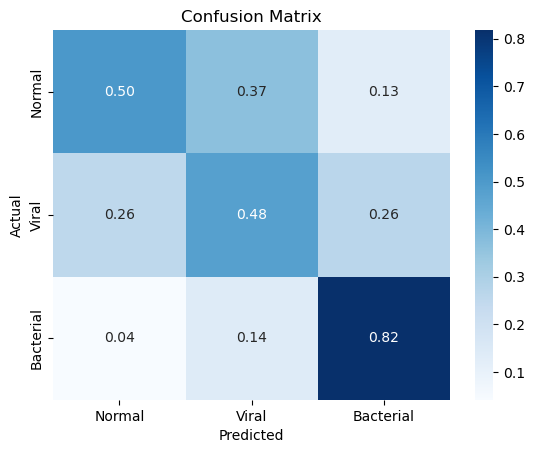

In [8]:
#Define path to save matrix image
IMAGE_DIR = "../../reports/figures/naive_bayes/"

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)  # Evaluate accuracy
    cm = confusion_matrix(y_true, y_pred)  # Generate classification report
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    # Normalize confusion matrix by row (true label count)
    confusionMatrix_ratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Plot confusion matrix
    sns.heatmap(confusionMatrix_ratio, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=["Normal", "Viral", "Bacterial"], 
                yticklabels=["Normal", "Viral", "Bacterial"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(IMAGE_DIR, "confusion_matrix_normalized.png"))
    plt.show()

evaluate_model(test_labels, y_pred)

The Naive Bayes model shows the best performance in identifying bacterial cases. Class 3 has the highest precision and recall values, at 0.74 and 0.82, respectively. This indicates that the model reliably classifies bacterial instances, with most predictions being correct.

Conversely, the model struggles with viral cases. For class 2, the precision is 0.37, and the recall is 0.48. These low values reflect the model's difficulty in accurately identifying viral cases, resulting in many misclassifications.

The model's performance for normal cases (class 1) is moderate, with a precision of 0.71 and a recall of 0.50. While it correctly identifies a fair number of normal instances, it still misses a significant portion, leading to a lower recall.

Overall, the model's accuracy is 0.62, meaning it correctly classifies 62% of instances. The confusion matrix reveals specific areas of misclassification, such as normal cases being confused with viral and bacterial cases.

### 5. Conclusion

In this notebook, we applied a **Naive Bayes classifier** to classify chest X-ray images from the **CoronaHack Chest X-Ray dataset**, following a structured approach:

- **Data Preprocessing**: We extracted metadata, assigned categorical labels, and partitioned the dataset into training and testing sets.  
- **Feature Extraction**: Images were converted to grayscale, resized, normalized, and flattened into feature vectors for model input.  
- **Model Training**: A **Gaussian Naive Bayes** classifier was trained on the processed data.  
- **Evaluation**: The model achieved an **accuracy of 55.00%**, with better classification performance for Bacterial Pneumonia cases but noticeable misclassification between Normal and Viral Pneumonia.  

Using **Naive Bayes** for image classification offers several advantages:

- **Simple and efficient**, requiring minimal computational resources.  
- **Works well with high-dimensional data**, as it assumes feature independence.  
- **Requires minimal training data**, making it suitable for smaller datasets.  

However, it also has notable limitations:

- **Strong independence assumption**, which may not hold for image data, leading to misclassification.  
- **Struggles with feature correlations**, making it less effective than more complex models.  
- **Lower accuracy compared to deep learning methods**, especially for complex visual patterns.  

In summary, Naive Bayes provided a quick and interpretable baseline for chest X-ray classification. However, its performance is limited by feature independence assumptions. **Further improvements** could be explored by using **feature engineering, more advanced probabilistic models, or deep learning approaches such as CNNs** to better capture spatial patterns in medical images.